In [1]:
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement
from numpy.random import multivariate_normal
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import accuracy_score
import numpy as np

from confidentlearning.noise_generation import generate_noise_matrix_from_trace, generate_noisy_labels
from confidentlearning.util import print_noise_matrix
from confidentlearning.latent_estimation import estimate_confident_joint_and_cv_pred_proba, estimate_latent
from confidentlearning.pruning import get_noise_indices
from confidentlearning.classification import RankPruning

In [2]:
def show_decision_boundary(clf, title):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


    plt.figure(figsize=(15, 12))
    plt.axis('off')

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=0.015)

    # Plot the distribution for viewing.
    for k in range(K):
        X_k = X_train[y_train == k] # data for class k
        plt.scatter(X_k[:,0], X_k[:, 1], color=[color_map[noisy_k] for noisy_k in s[y_train==k]], s=150, marker=r"${a}$".format(a=str(k)), linewidth=1)
    plt.scatter(X_train[:,0][s != y_train], X_train[:,1][s != y_train], s=400, facecolors='none', edgecolors='green', linewidth=0.8)
    plt.title(title, fontsize=25)
    plt.show()

In [3]:
seed = 46 # Seeded for reproducibility - remove to created random noise and distributions.
np.random.seed(seed = seed)

means = [ [3, 2], [7, 7], [0, 8] ]
covs = [ [[5, -1.5],[-1.5, 1]] , [[1, 0.5],[0.5, 4]], [[5, 1],[1, 5]] ]

K = len(means) # number of classes
sizes = [ 800, 400, 400 ]
data = []
labels = []
test_data = []
test_labels = []

for idx in range(len(means)):
    data.append(multivariate_normal(mean=means[idx], cov=covs[idx], size=sizes[idx]))
    test_data.append(multivariate_normal(mean=means[idx], cov=covs[idx], size=sizes[idx]))
    labels.append(np.array([idx for i in range(sizes[idx])]))
    test_labels.append(np.array([idx for i in range(sizes[idx])]))
X_train = np.vstack(data)
y_train = np.hstack(labels)
X_test = np.vstack(test_data)
y_test = np.hstack(test_labels) 

# Compute p(y=k)
py = np.bincount(y_train) / float(len(y_train))

noise_matrix = generate_noise_matrix_from_trace(
  K, 
  avg_trace=0.5,
  py=py,
  valid_noise_matrix=True,
)

# Generate our noisy labels using the noise_marix.
s = generate_noisy_labels(y_train, noise_matrix)
ps = np.bincount(s) / float(len(s))

confident_joint, psx = estimate_confident_joint_and_cv_pred_proba(X_train, s, seed=seed)
est_py, est_noise_matrix, est_inverse_noise_matrix = estimate_latent(confident_joint, s)
idx_errors = get_noise_indices(s, psx)

#### To show off the power of **confidentlearning**, we've chosen an example of multiclass learning with noisy labels in which over 50% of the training labels are wrong.
Toggle the ```avg_trace``` parameter in ```generate_noise_matrix_from_trace``` above to try out different amounts of noise.

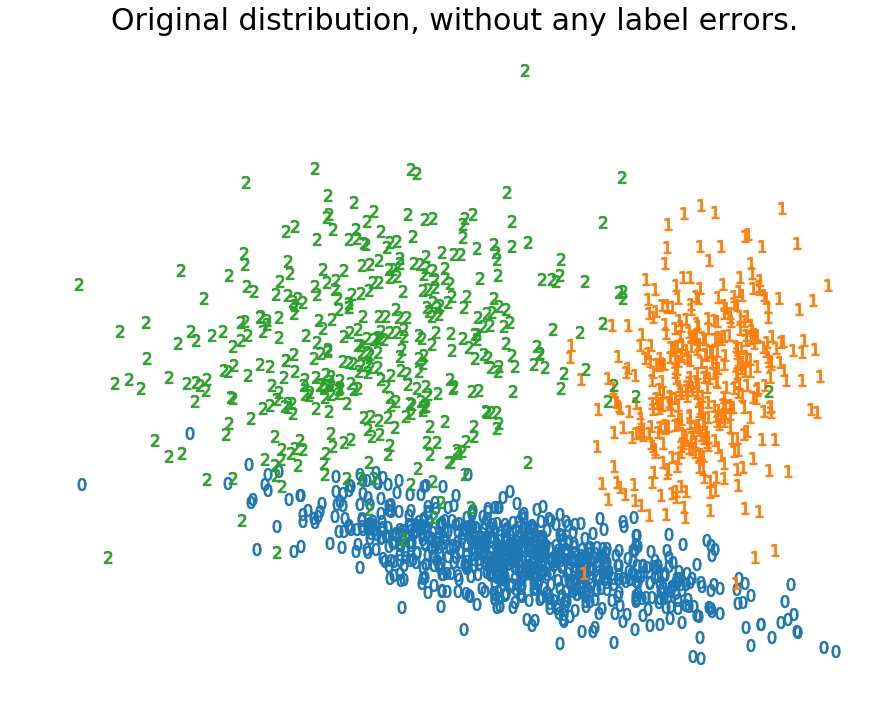

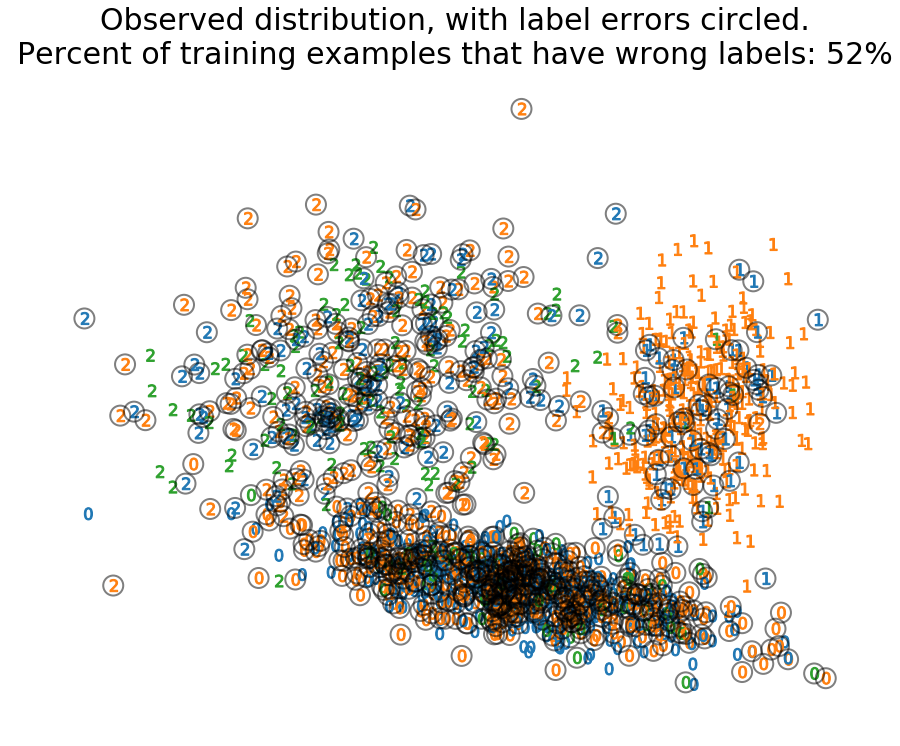

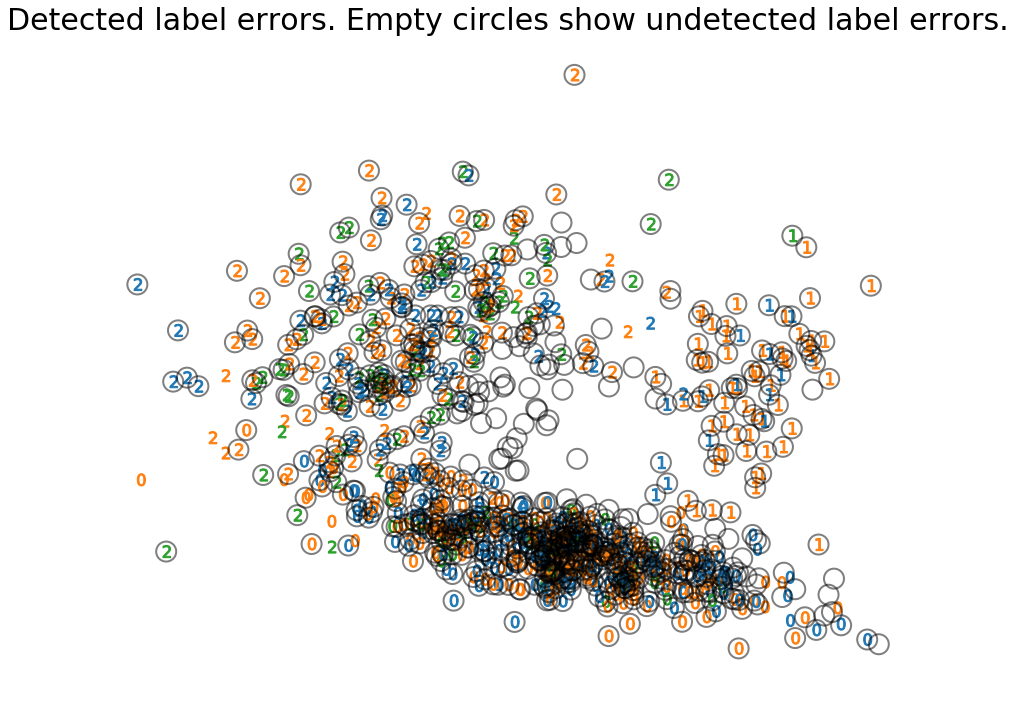

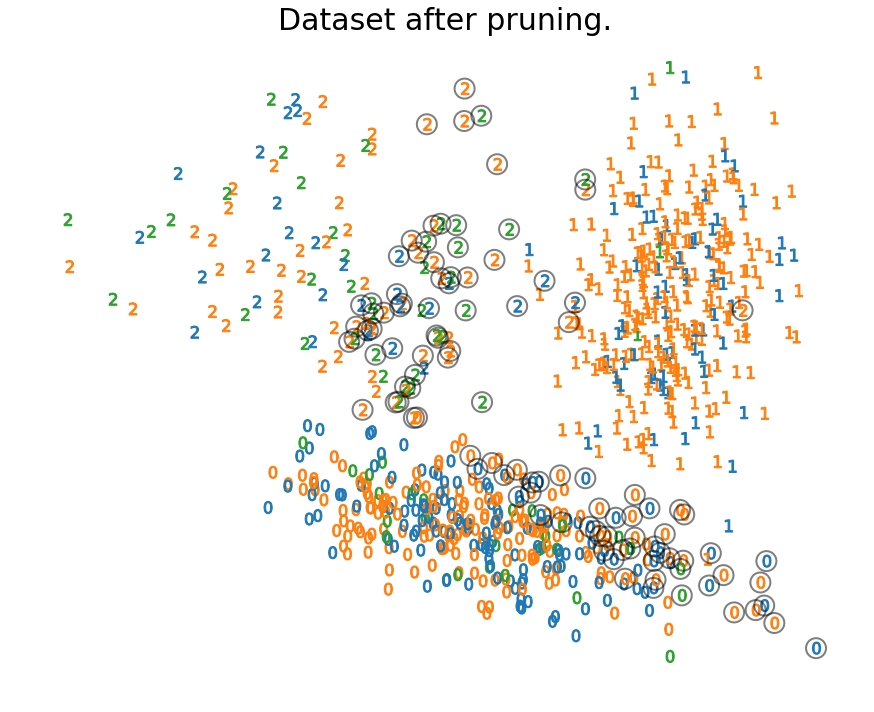


The actual, latent, underlying Noise Matrix (Noisy Channel):
	y=0	y=1	y=2
	---	---	---
s=0 |	0.42	0.18	0.28
s=1 |	0.5	0.81	0.45
s=2 |	0.08	0.01	0.27


Our estimate of the Noise Matrix (Noisy Channel):
	y=0	y=1	y=2
	---	---	---
s=0 |	0.42	0.22	0.32
s=1 |	0.5	0.7	0.46
s=2 |	0.09	0.07	0.22

Accuracy Comparison
-------------------
Logistic regression: 0.310625
Logistic regression (+rankpruning): 0.919375
Fit on denoised data without re-weighting: 0.868125









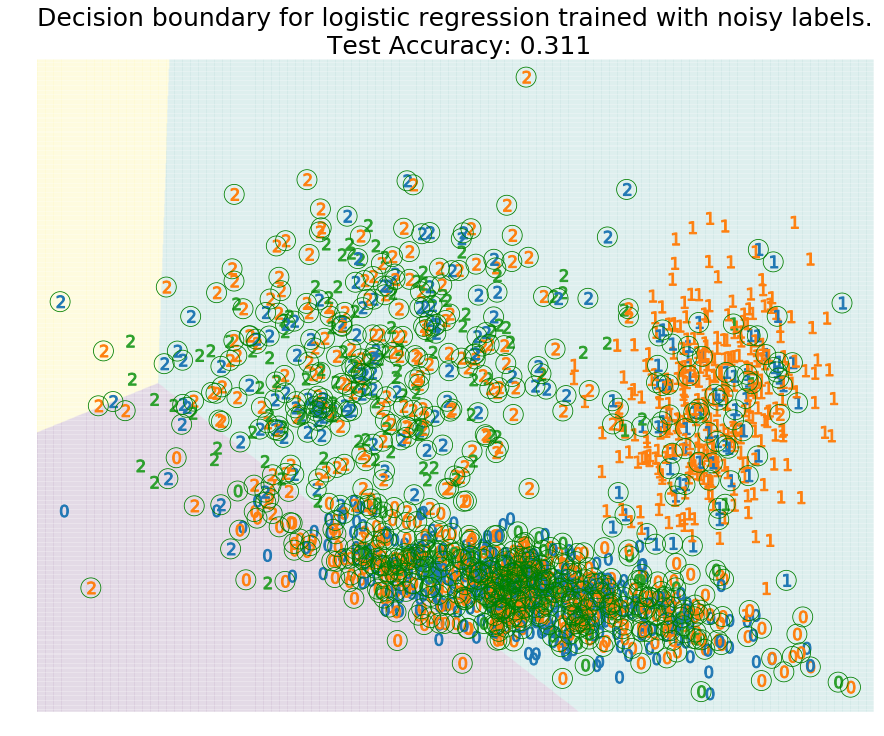

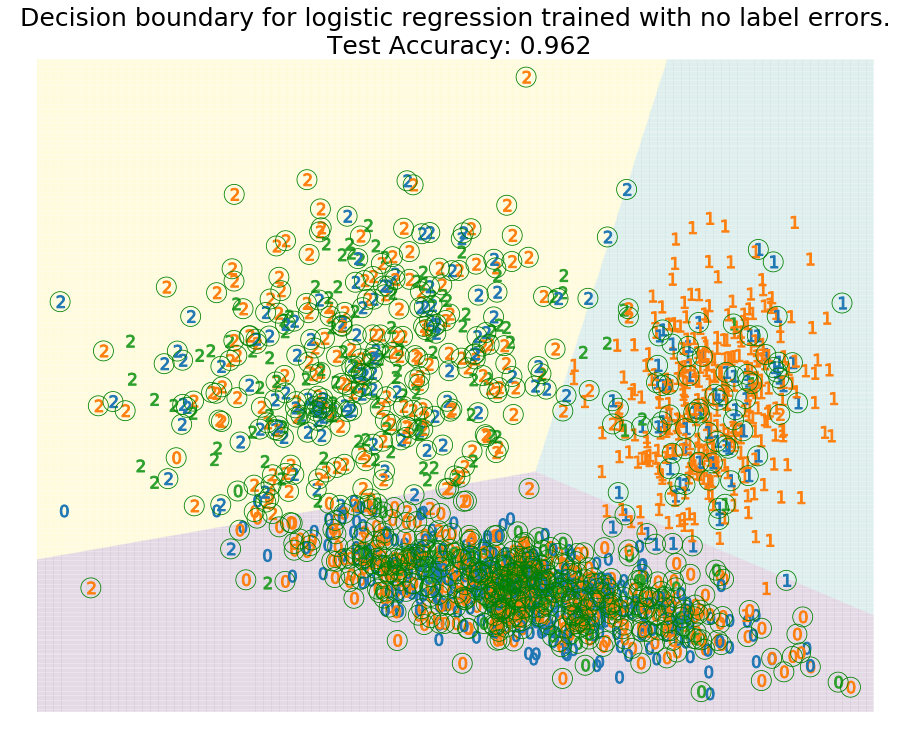

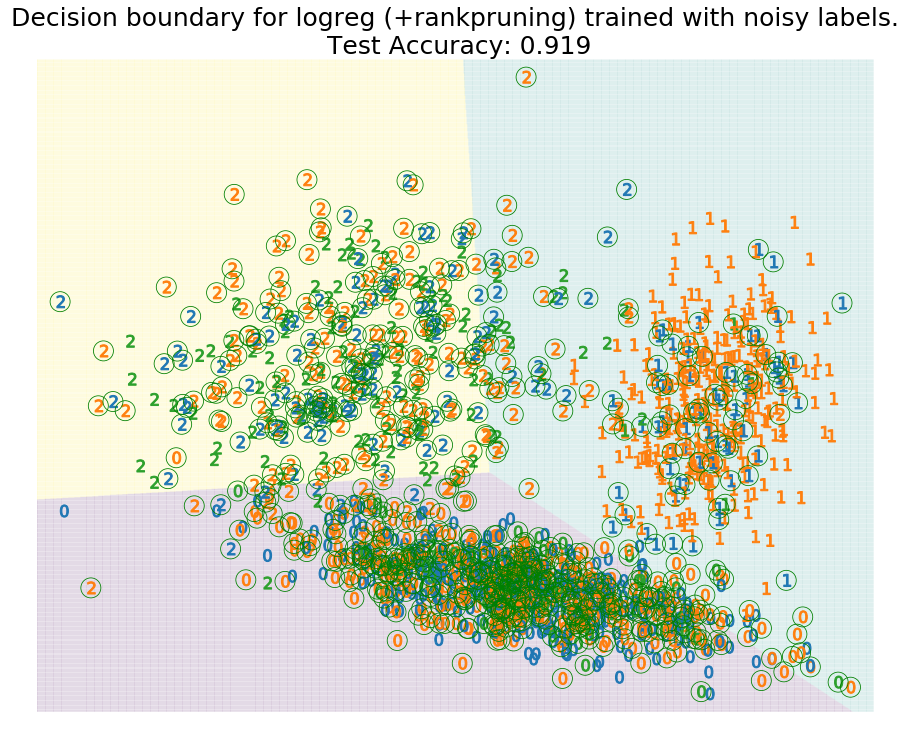

In [4]:
true_joint_distribution_of_label_errors = (noise_matrix * py)
percent_error_str = 'Percent of training examples that have wrong labels: ' + \
      str(int(round(100 - 100*true_joint_distribution_of_label_errors.trace()))) + "%"

colors = [(31 / 255., 119 / 255., 180 / 255.), (255 / 255., 127 / 255., 14 / 255.), (44 / 255., 160 / 255., 44 / 255.)]
color_map = dict(zip(range(len(colors)), colors))
try:
# Plot the distribution for your viewing.
    % matplotlib inline
    from matplotlib import pyplot as plt
    plt.figure(figsize=(15, 12))
    plt.axis('off')
    for k in range(K):
        X_k = X_train[y_train==k] # data for class k
        plt.scatter(X_k[:,0], X_k[:, 1], color=colors[k], s=150, marker=r"${a}$".format(a=str(k)), linewidth=1)
    plt.title("Original distribution, without any label errors.", fontsize=30)

    print("\n\n\n\n")

    # Plot the noisy distribution for viewing.
    plt.figure(figsize=(15, 12))
    plt.axis('off')
    for k in range(K):
      X_k = X_train[y_train == k] # data for class k
      plt.scatter(X_k[:,0], X_k[:, 1], color=[color_map[noisy_k] for noisy_k in s[y_train==k]], s=150, marker=r"${a}$".format(a=str(k)), linewidth=1)
    plt.scatter(X_train[:,0][s != y_train], X_train[:,1][s != y_train], s=400, facecolors='none', edgecolors='black', linewidth=2, alpha = 0.5)
    plt.title('Observed distribution, with label errors circled.\n'+percent_error_str, fontsize=30)
    plt.show()

    print("\n\n\n\n")

    # Plot the noisy distribution for viewing.
    plt.figure(figsize=(15, 12))
    plt.axis('off')
    for k in range(K):
      X_k = X_train[idx_errors & (y_train == k)] # data for class k
      plt.scatter(X_k[:,0], X_k[:, 1], color=[color_map[noisy_k] for noisy_k in s[y_train==k]], s=150, marker=r"${a}$".format(a=str(k)), linewidth=1)
    plt.scatter(X_train[:,0][s != y_train], X_train[:,1][s != y_train], s=400, facecolors='none', edgecolors='black', linewidth=2, alpha = 0.5)
    plt.title('Detected label errors. Empty circles show undetected label errors.', fontsize=30)
    plt.show()


    print("\n\n\n\n")

    plt.figure(figsize=(15, 12))
    plt.axis('off')
    for k in range(K):
      X_k = X_train[~idx_errors & (y_train == k)] # data for class k
      plt.scatter(X_k[:,0], X_k[:, 1], color=[color_map[noisy_k] for noisy_k in s[y_train==k]], s=150, marker=r"${a}$".format(a=str(k)), linewidth=1)
    plt.scatter(X_train[~idx_errors][:,0][s[~idx_errors] != y_train[~idx_errors]], X_train[~idx_errors][:,1][s[~idx_errors] != y_train[~idx_errors]], s=400, facecolors='none', edgecolors='black', linewidth=2, alpha = 0.5)
    plt.title('Dataset after pruning.', fontsize=30)
    plt.show()
except:
    print("Plotting is only supported in an iPython interface.")

print_noise_matrix(noise_matrix, 'The actual, latent, underlying')
print_noise_matrix(est_noise_matrix, 'Our estimate of the')
print("Accuracy Comparison")
print("-------------------")
clf = logreg()
baseline_score = accuracy_score(y_test, clf.fit(X_train, s).predict(X_test))
print("Logistic regression:", baseline_score)
rp = RankPruning(seed = seed)
rp_score = accuracy_score(y_test, rp.fit(X_train, s, psx=psx).predict(X_test))
print("Logistic regression (+rankpruning):", rp_score)
diff = rp_score - baseline_score
clf = logreg()
# If we fit on the pruned dataset without reweighting, performance is much worse.
print('Fit on denoised data without re-weighting:', accuracy_score(y_test, clf.fit(X_train[~idx_errors], s[~idx_errors]).predict(X_test)))



try:
    % matplotlib inline
    from matplotlib import pyplot as plt
    
    print("\n\n\n\n\n\n")
    
    clf = logreg()
    clf.fit(X_train, s)
    show_decision_boundary(clf, 'Decision boundary for logistic regression trained with noisy labels.\n Test Accuracy: ' + str(round(baseline_score, 3)))

    clf.fit(X_train, y_train)
    max_score = accuracy_score(y_test, clf.predict(X_test))
    show_decision_boundary(clf, 'Decision boundary for logistic regression trained with no label errors.\n Test Accuracy: ' + str(round(max_score, 3)))

    show_decision_boundary(rp.clf, 'Decision boundary for logreg (+rankpruning) trained with noisy labels.\n Test Accuracy: ' + str(round(rp_score, 3)))
except:
    print("Plotting is only supported in an iPython interface.")